In [1]:
# Usual Libraries
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import os
# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Modeling

In [2]:
song_data=pd.read_csv('song_data.csv',index_col=0)

In [3]:
song_classic=song_data[song_data['gnr_code']=='클래식'].sample(3000)
song_rap=song_data[song_data['gnr_code']=='랩/힙합'].sample(4000)
song_ballade=song_data[song_data['gnr_code']=='발라드']
song_rock=song_data[song_data['gnr_code']=='록/메탈']

In [4]:
song_data=pd.concat([song_classic,song_rap,song_ballade,song_rock])

In [5]:
genre_list = song_data['gnr_code']
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [6]:
y

array([3, 3, 3, ..., 1, 1, 1])

In [7]:
encoder.classes_

array(['랩/힙합', '록/메탈', '발라드', '클래식'], dtype=object)

In [8]:
X=song_data.iloc[:, 1:]

# Normalization

In [9]:
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler() # 정규화
np_scaled = min_max_scaler.fit_transform(X)

In [10]:
X = pd.DataFrame(np_scaled, columns = cols)

In [11]:
X,y = shuffle(X,y, random_state=2)

# Train, Test set Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
len(y_train)

15979

In [14]:
len(y_test)

3995

# Model Selection

In [15]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [16]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.61391 

Accuracy Stochastic Gradient Descent : 0.74962 

Accuracy KNN : 0.75284 

Accuracy Decission trees : 0.67873 

Accuracy Random Forest : 0.75455 

Accuracy Support Vector Machine : 0.77009 

Accuracy Logistic Regression : 0.77047 

Accuracy Neural Nets : 0.7682 

Accuracy Cross Gradient Booster : 0.80724 

Accuracy Cross Gradient Booster (Random Forest) : 0.75701 



Accuracy : 0.78498 



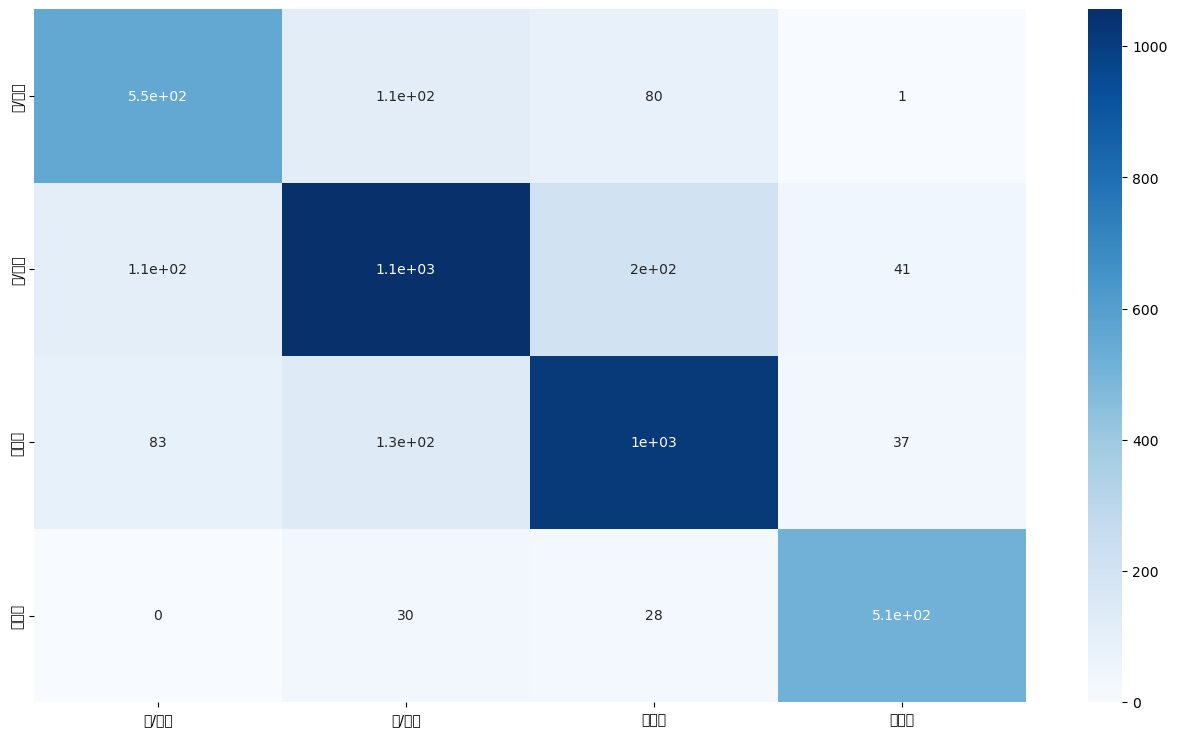

In [15]:
# Final model
xgb = XGBClassifier(n_estimators=2000, learning_rate=0.01)
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ['랩/힙합', '록/메탈', '발라드', '클래식'],
           yticklabels=['랩/힙합', '록/메탈', '발라드', '클래식']);
plt.savefig("conf matrix")

In [25]:
for songname in os.listdir('song'):
    y,sr=librosa.load(f'song/{songname}',sr=16000)
    mel = librosa.feature.melspectrogram(y=y,sr=sr,win_length=512,hop_length=256,n_mels=48)
    mel_db=librosa.power_to_db(mel,ref=np.max)
    header=''
    for i in range(1, 49):
        header += f' mel_mean{i}' 
        header += f' mel_var{i}'
    header = header.split()
    to_append=''

    file = open(f'{songname}.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    for e in mel_db:
        to_append += f' {np.mean(e)}'
        to_append += f' {np.var(e)}'
    file = open(f'{songname}.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

In [27]:
for song in os.listdir('song'):
    data=pd.read_csv(f'{song}.csv')
    pred = xgb.predict(np.array(data))
    print(f"{song}은 '{pred}'입니다.")

Hello.wav은 '[3]'입니다.
가시.wav은 '[3]'입니다.
나의사춘기에게-볼빤간.wav은 '[3]'입니다.
내사랑내곁에 - 김현식.wav은 '[3]'입니다.
너를사랑해-한동준.wav은 '[3]'입니다.
너무아픈사랑-박새별.wav은 '[3]'입니다.
너의 모든 순간.wav은 '[3]'입니다.
다시-오현란 30.wav은 '[3]'입니다.
밤편지-아이우.wav은 '[3]'입니다.
사랑했지만-김광석.wav은 '[3]'입니다.
투비-루다.wav은 '[3]'입니다.
